<a href="https://colab.research.google.com/github/246008-svg/Local_Project/blob/main/random_forest_iris_interactive_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0

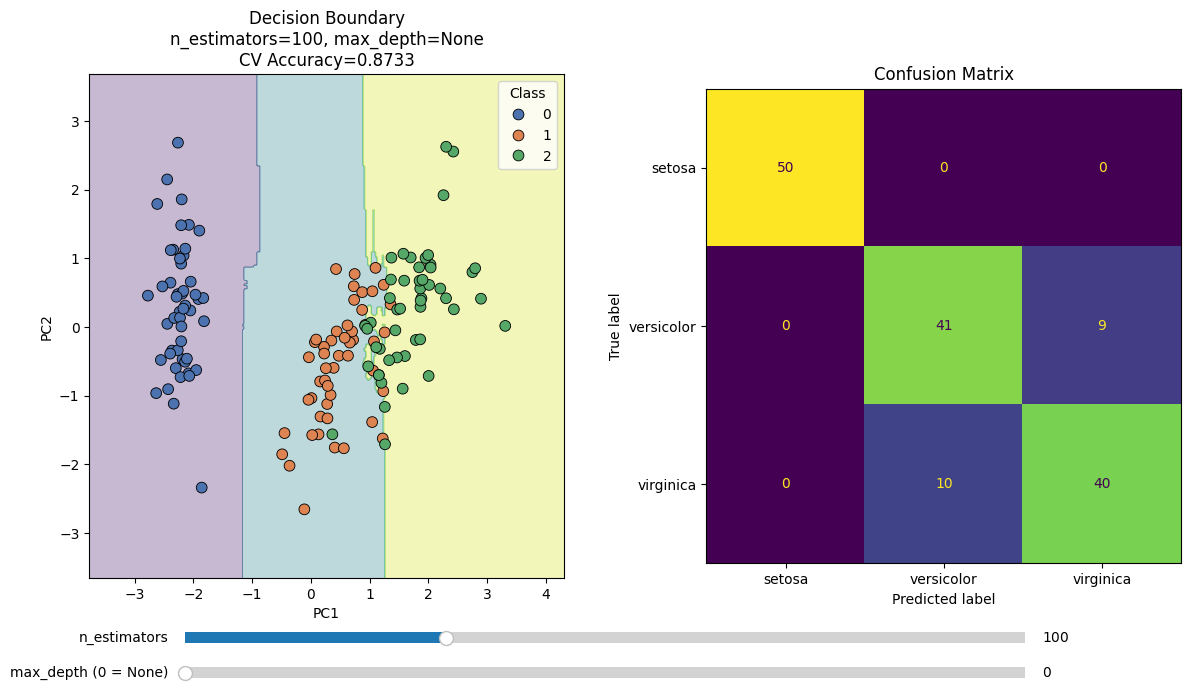

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# -----------------------------------------------------
# 1) Load and preprocess data
# -----------------------------------------------------
iris = load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Scale features then apply PCA -> 2D for plotting decision boundary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Stratified 3-fold CV (used for confusion matrix)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# -----------------------------------------------------
# 2) Precompute mesh grid for decision boundary
# -----------------------------------------------------
x_min, x_max = X_pca[:, 0].min() - 1.0, X_pca[:, 0].max() + 1.0
y_min, y_max = X_pca[:, 1].min() - 1.0, X_pca[:, 1].max() + 1.0

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# -----------------------------------------------------
# 3) Helper function: train RF, compute decision boundary + confusion matrix
# -----------------------------------------------------
def compute_results(n_estimators, max_depth):
    """
    Train RandomForest with given parameters.
    Return:
      - Z: predicted class for each grid point (for decision boundary)
      - cm: confusion matrix (using cross_val_predict)
      - acc: mean CV accuracy
    """
    depth_param = None if max_depth == 0 else max_depth

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=depth_param,
        random_state=42
    )

    # Cross-validated predictions for confusion matrix
    y_pred_cv = cross_val_predict(model, X_pca, y, cv=cv)
    cm = confusion_matrix(y, y_pred_cv)
    acc = accuracy_score(y, y_pred_cv)

    # Fit on all data for decision boundary
    model.fit(X_pca, y)
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    return Z, cm, acc

# -----------------------------------------------------
# 4) Initial parameters and initial computation
# -----------------------------------------------------
init_n_estimators = 100
init_max_depth = 0  # 0 will mean None

Z_init, cm_init, acc_init = compute_results(init_n_estimators, init_max_depth)

# -----------------------------------------------------
# 5) Create figure with 2 axes + space for sliders
# -----------------------------------------------------
plt.close('all')
fig = plt.figure(figsize=(12, 7))
fig.subplots_adjust(left=0.07, right=0.98, top=0.92, bottom=0.20, wspace=0.3)

ax_decision = fig.add_subplot(1, 2, 1)  # left: decision boundary
ax_conf = fig.add_subplot(1, 2, 2)      # right: confusion matrix

# -----------------------------------------------------
# 6) Initial Decision Boundary plot
# -----------------------------------------------------
# Background regions
contour = ax_decision.contourf(xx, yy, Z_init, alpha=0.3)

# Data points
scatter = sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=y, palette='deep', s=60,
    edgecolor='black', ax=ax_decision
)

ax_decision.set_title(
    f"Decision Boundary\nn_estimators={init_n_estimators}, max_depth=None\nCV Accuracy={acc_init:.4f}"
)
ax_decision.set_xlabel("PC1")
ax_decision.set_ylabel("PC2")
ax_decision.legend(title="Class", loc='upper right')

# -----------------------------------------------------
# 7) Initial Confusion Matrix plot
# -----------------------------------------------------
conf_disp = ConfusionMatrixDisplay(confusion_matrix=cm_init, display_labels=class_names)
conf_disp.plot(ax=ax_conf, colorbar=False)
ax_conf.set_title("Confusion Matrix")
ax_conf.set_xlabel("Predicted label")
ax_conf.set_ylabel("True label")

# -----------------------------------------------------
# 8) Create slider axes (bottom)
# -----------------------------------------------------
ax_n_est = plt.axes([0.15, 0.10, 0.70, 0.03])   # [left, bottom, width, height]
ax_depth = plt.axes([0.15, 0.05, 0.70, 0.03])

slider_n_estimators = Slider(
    ax=ax_n_est,
    label='n_estimators',
    valmin=10,
    valmax=300,
    valinit=init_n_estimators,
    valstep=10
)

slider_max_depth = Slider(
    ax=ax_depth,
    label='max_depth (0 = None)',
    valmin=0,
    valmax=10,
    valinit=init_max_depth,
    valstep=1
)

# -----------------------------------------------------
# 9) Update function when sliders move
# -----------------------------------------------------
def update(val):
    # Read slider values
    n_est = int(slider_n_estimators.val)
    depth = int(slider_max_depth.val)

    # Recompute model outputs
    Z, cm, acc = compute_results(n_est, depth)

    # ----- Update decision boundary -----
    ax_decision.clear()
    ax_decision.contourf(xx, yy, Z, alpha=0.3)

    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1],
        hue=y, palette='deep', s=60,
        edgecolor='black', ax=ax_decision
    )

    depth_txt = "None" if depth == 0 else str(depth)
    ax_decision.set_title(
        f"Decision Boundary\nn_estimators={n_est}, max_depth={depth_txt}\nCV Accuracy={acc:.4f}"
    )
    ax_decision.set_xlabel("PC1")
    ax_decision.set_ylabel("PC2")
    ax_decision.legend(title="Class", loc='upper right')

    # ----- Update confusion matrix -----
    ax_conf.clear()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax_conf, colorbar=False)
    ax_conf.set_title("Confusion Matrix")
    ax_conf.set_xlabel("Predicted label")
    ax_conf.set_ylabel("True label")

    # Redraw the whole figure
    fig.canvas.draw_idle()

# Connect sliders to update()
slider_n_estimators.on_changed(update)
slider_max_depth.on_changed(update)


